In [618]:
import aestream
import h5py
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
!ls ../basic_shapes/2024_01_22_12_01_03_circle_none_trans_right_processed/

events.aedat4  frames.h5  metadata.txt	positions.json


In [3]:
import sparse

In [694]:
# file_rec = "../basic_shapes/circle/affine/2024_01_30_13_12_31_circle_none_affine_right_processed/frames.h5"
file_rec = "frames.h5"
# "../basic_shapes/triangle/affine/2024_02_04_21_13_14_triagle_none_affine_right_processed/frames.h5"

In [695]:
with h5py.File(file_rec) as f:
    co = f["frame_keys"][:]
    val = torch.from_numpy(f["frame_values"][:]).int()

In [696]:
to_list = lambda x: np.array([x[i] for i in range(4)])

In [697]:
# coos = np.vectorize(to_list, signature="()->(4)")(co)
coos = []
for i in tqdm.tqdm(co[-1000000:]):
    coos.append(to_list(i))

100%|██████████████████████████| 1000000/1000000 [00:03<00:00, 275103.87it/s]


In [698]:
coos = torch.from_numpy(np.array(coos, dtype=np.int64))

In [699]:
sp = torch.sparse_coo_tensor(coos.T, val[-1000000:])
coos.shape, val[-1000000:].shape

(torch.Size([1000000, 4]), torch.Size([1000000]))

In [700]:
sp

tensor(indices=tensor([[7484, 7484, 7484,  ..., 8014, 8014, 8014],
                       [   0,    0,    0,  ...,    0,    0,    0],
                       [ 939,  940,  941,  ..., 1271, 1272, 1278],
                       [ 124,  109,  123,  ...,  105,  583,  591]]),
       values=tensor([1, 1, 1,  ..., 1, 1, 1]),
       size=(8015, 2, 1280, 720), nnz=1000000, dtype=torch.int32,
       layout=torch.sparse_coo)

In [701]:
def to_frames(frames, start, count):
    f = []
    for i in tqdm.trange(count):
        f.append(frames[i + start].to_dense())
    f = torch.stack(f) * 255
    zeros = torch.zeros(len(f), 1, *f.shape[2:])
    return torch.concat([f, zeros], dim=1).permute(0, 3, 2, 1)

video = to_frames(sp, 8014 - 100, 100)

100%|██████████████████████████████████████| 100/100 [00:01<00:00, 92.29it/s]


In [ ]:
torchvision.io.write_video("vid.mp4", video, fps=10)

In [ ]:
<video src="vid.mp4" autoplay loop controls/>

# Draw masks

In [683]:
import math
import scipy
import cv2
triangle_offset =  -0;
triangle_width = 0.29;
triangle_height =  triangle_width / 2 * math.tan(60 * math.pi / 180);
triangle_center = triangle_width * math.sqrt(3) / 3;
triangle_polygon = [
        [-(triangle_center), 0, 0],
        [triangle_height - triangle_center, 0, -triangle_width / 2],
        [triangle_height - triangle_center, 0, triangle_width / 2],
        [-(triangle_center), 0, 0]
]
circle_radius = 0.292/2;
iterations = 150;
circle_polygon = []
for i in range(iterations):
    circle_polygon.append([
        math.sin(2 * math.pi * i / iterations) * circle_radius, 
        0,
        math.cos(2 * math.pi * i / iterations) * circle_radius,
    ]);

    
offset_x = 0.28 / 2 - 0.022154 - 0.05;
offset_z = 0.22 / 2 + 0.1 + 0.05;
blob_polygon = [
    [offset_x, 0, offset_z],
    [offset_x + 0.022154, 0, offset_z],
    [offset_x + 0.022154, 0, offset_z - 0.1],
    [offset_x + 0.022154 + 0.05, 0, offset_z - 0.05 - 0.1],
    [offset_x + 0.022154 + 0.05, 0, offset_z - 0.05 - 0.1 - 0.22],
    [offset_x + 0.022154 + 0.05 - 0.28, 0, offset_z - 0.05 - 0.1 - 0.22],
    [offset_x + 0.022154 + 0.05 - 0.28, 0, offset_z - 0.05 - 0.1 - 0.22 + 0.25],
    [offset_x, 0, offset_z],
]

In [703]:
with h5py.File(file_rec) as f:
    poses = f["blob"][-100:]
poses.shape

(100, 9)

In [685]:
poses.shape, video.shape

((100, 7), torch.Size([100, 720, 1280, 3]))

In [686]:
poses[0]

array([ 8.3294513e+02,  2.9914548e+02, -9.9012536e-01, -6.5459305e-01,
       -1.8945864e-01,  7.3019433e-01, -4.9291290e-02], dtype=float32)

In [687]:
camera_matrix = np.array([[1700.74372, 0, 650.172869],
                 [0, 1700.74372, 285.398327],
                 [0, 0, 1]])
vec = np.array([0, 0, 0], dtype=np.float32)
distortion_coeff = np.array([0, 0, 0, 0, 0], dtype=np.float32)

In [808]:
def position_to_pixel(points, pose):
    (px, py, cx, cy, cz, qx, qy, qz, qw) = pose
    print(px, py, cx, cy, cz)
    rotation = scipy.spatial.transform.Rotation.from_quat([qx, qy, qz, qw])
    new_points = [[p[0], -p[1], -p[2]] for p in points] # Convert to opencv
    rotated_points = rotation.apply(new_points)
    relative_points = rotated_points + np.array([cx, -cy, -cz]) # Convert to opencv
    projected_points, _ = cv2.projectPoints(relative_points, vec, vec, camera_matrix, distortion_coeff)
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]
    return projected_points# - np.array([x, 0])
    #return projected_points - np.array([cx, cy])) * np.array([-1, 1]) + np.array([cx, cy])
    #return (projected_points - np.array([cx, cy])) * np.array([-1, 1]) + np.array([x, y])

position_to_pixel([[0, 0, 0]], poses[0])

832.9106 299.3882 0.10640489 -0.0080031995 -0.99012536


array([[[832.94513338, 299.14546632]]])

856.32697 309.92465 0.120637015 -0.014165205 -0.99527967
856.32697 309.92465 0.120637015 -0.014165205 -0.99527967


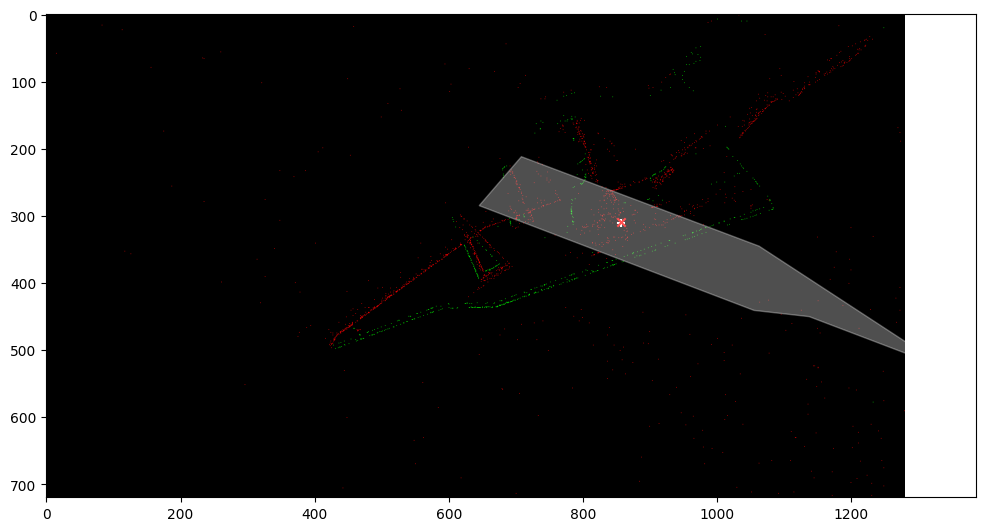

In [809]:
def draw_frame(frame, pose, polygon):
    f, a = plt.subplots(1, 1, figsize=(12, 7))
    a.imshow(frame)
    plt.scatter([pose[0]], [pose[1]], marker="+", color="white")
    center = position_to_pixel([[0,0,0]], pose).reshape(-1, 2)
    plt.scatter([center[0,0]], [center[0,1]], marker="x", color="red")
    pixels = position_to_pixel(polygon, pose).reshape(-1, 2)
    plt_polygon = plt.Polygon(pixels, color="#ffffff50")
    a.add_patch(plt_polygon)

n = 70
draw_frame(video[n + 8], poses[n], blob_polygon)

# Test hdf5 layout

In [ ]:
!ls -alh test.hdf5

In [19]:
with h5py.File("test.hdf5", "w") as f:
    for i in tqdm.trange(100000):
        arr = np.empty((4, 100000), dtype=np.uint8)
        f.create_dataset(str(i), data=arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:28<00:00, 1128.61it/s]


In [2]:
%%timeit
n = torch.randint(0, 10000, (1,)).item()
with h5py.File("test.hdf5", "r") as f:
    coos = f[f"{n}"][:]
    t = torch.sparse_coo_tensor(indices=coos, values=torch.ones(len(coos[0])), dtype=torch.int8)
t.shape

2.66 ms ± 55.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
%%timeit
n = torch.randint(0, 10000, (1,)).item()
with h5py.File("test.hdf5", "r") as f:
    coos = torch.from_numpy(f[f"{n}"][:]).cuda()
    t = torch.sparse_coo_tensor(indices=coos, values=torch.ones(len(coos[0]), device="cuda"), dtype=torch.int8, device="cuda").to_dense()
t.shape

253 ms ± 26.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
%%timeit
n = torch.randint(0, 10000, (1,)).item()
with h5py.File("test.hdf5", "r") as f:
    coos = f[f"{n}"][:]
    t = torch.sparse_coo_tensor(indices=coos, values=torch.ones(len(coos[0])), dtype=torch.int8).to_dense().cuda()
t.shape

28.8 ms ± 13.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Test AEStream

In [ ]:
!ls ../basic_shapes/triangle/affine/2024_02_04_21_13_14_triagle_none_affine_right_processed/

In [ ]:
import time
with aestream.FileInput("../basic_shapes/triangle/affine/2024_02_04_21_13_14_triagle_none_affine_right_processed/events.aedat4", (1280, 720)) as fp:
    fp.read()
    time.sleep(2)
    print(fp.read().sum())